# Detecting Cyberbullying in Tweets
***

In [1]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from time import time

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib

### Loading and Analyzing the data
***

In [3]:
df_scraped = pd.read_csv('labeled_tweets.csv')
df_public = pd.read_csv('public_data_labeled.csv')
df_scraped.head()


,id,label,full_text
0,572342978255048705,Offensive,So Drasko just said he was impressed the girls...
1,572342978255048705,Offensive,So Drasko just said he was impressed the girls...
2,572341498827522049,Offensive,Drasko they didn't cook half a bird you idiot ...
3,572341498827522049,Offensive,Drasko they didn't cook half a bird you idiot ...
4,572340476503724032,Offensive,Hopefully someone cooks Drasko in the next ep ...


In [4]:
df_scraped.drop_duplicates(inplace = True)
df_scraped.drop('id', axis = 'columns', inplace = True)

df_public.drop_duplicates(inplace = True)

In [5]:
df_scraped.head(5)

,label,full_text
0,Offensive,So Drasko just said he was impressed the girls...
2,Offensive,Drasko they didn't cook half a bird you idiot ...
4,Offensive,Hopefully someone cooks Drasko in the next ep ...
6,Offensive,of course you were born in serbia...you're as ...
7,Offensive,These girls are the equivalent of the irritati...


In [6]:
df_public.head(5)
df_public.loc[1,:]

label                                                Offensive
full_text    !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
Name: 1, dtype: object

In [7]:
df = pd.concat([df_scraped, df_public])

In [8]:
df.shape

(35787, 2)

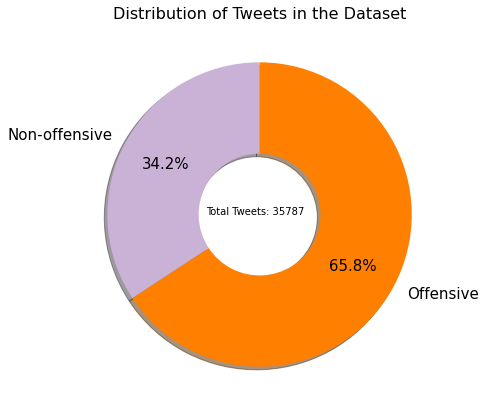

In [9]:
plt.figure(figsize = (7,7))
sorted_counts = df['label'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(df.shape[0]))
plt.title('Distribution of Tweets in the Dataset', fontsize = 16);

In [10]:
df['label'] = df.label.map({'Offensive': 1, 'Non-offensive': 0})

### Implementing a training and predicting Pipeline
***

Separate training and testing data:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['full_text'], 
                                                    df['label'], 
                                                    random_state=42)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 35787
Number of rows in the training set: 26840
Number of rows in the test set: 8947


Vectorize the data:

In [12]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer(stop_words = 'english', lowercase = True)

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_train)

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
testing_data = count_vector.transform(X_test)

Implement Pipeline:

In [13]:
def pipeline(learner_list, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    # Get length of Training Data:
    size = len(y_train)
    
    results = {}
    final_results = []
    
    for learner in learner_list:
        
        # Store the learner name:
        results['Algorithm'] = learner.__class__.__name__

        # Fit the learner:
        start = time() # Get start time
        print("Training {}".format(learner.__class__.__name__))
        learner = learner.fit(X_train, y_train)
        end = time() # Get end time

        # Store the training time
        results['Training Time'] = end - start

        start = time() # Get start time
        predictions_test = learner.predict(X_test)
        predictions_train = learner.predict(X_train)
        end = time() # Get end time

        # Store the prediction time
        results['Prediction Time'] = end - start

        # Compute the Accuracy on Test Set
        results['Accuracy: Test'] = accuracy_score(y_test, predictions_test)

        # Compute the Accuracy on Training Set
        results['Accuracy: Train'] = accuracy_score(y_train, predictions_train)

        # Compute the F1 Score on Test Set
        results['F1 Score: Test'] = f1_score(y_test, predictions_test)

        # Compute the F1 Score on Training Set
        results['F1 Score: Train'] = f1_score(y_train, predictions_train)

        # Compute the Precision on Test Set
        results['Precision: Test'] = precision_score(y_test, predictions_test)

        # Compute the Precision on Training Set
        results['Precision: Train'] = precision_score(y_train, predictions_train)

        # Compute the Recall on Test Set
        results['Recall: Test'] = recall_score(y_test, predictions_test)

        # Compute the Recall on Training Set
        results['Recall: Train'] = recall_score(y_train, predictions_train)

        # Success
        print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
        print('----------------------------------------------------')
        
        final_results.append(results.copy())
    # Return a dataframe of the results
    return final_results

Put Algorithms in Pipeline:

In [14]:
# make a list of models
models = [ DecisionTreeClassifier(), LinearSVC(), 
          RandomForestClassifier(),
         LogisticRegression(), KNeighborsClassifier()]

In [15]:
re = pipeline(models, training_data, y_train, testing_data, y_test)
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

Training DecisionTreeClassifier
Training DecisionTreeClassifier finished in 4.09 sec
----------------------------------------------------
Training LinearSVC
Training LinearSVC finished in 0.60 sec
----------------------------------------------------
Training RandomForestClassifier
Training RandomForestClassifier finished in 50.94 sec
----------------------------------------------------
Training LogisticRegression


C:\Users\Santhosh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training LogisticRegression finished in 1.10 sec
----------------------------------------------------
Training KNeighborsClassifier


C:\Users\Santhosh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Training KNeighborsClassifier finished in 0.00 sec
----------------------------------------------------


In [16]:
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

### Analyze the results of the Pipeline
***

In [17]:
results.reset_index(drop = True)

,Algorithm,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
0,DecisionTreeClassifier,0.925897,0.954680,0.931463,0.942928,0.025985,0.998845,0.999943,0.998300,0.999121,4.091656
1,LogisticRegression,0.926344,0.964089,0.922279,0.942721,0.001998,0.978726,0.990241,0.977282,0.983719,1.095630
2,LinearSVC,0.916732,0.946599,0.925510,0.935936,0.002002,0.997019,0.998298,0.997167,0.997733,0.599652
3,RandomForestClassifier,0.915726,0.946516,0.923980,0.935112,3.285120,0.998845,0.999263,0.998980,0.999122,50.939847
4,KNeighborsClassifier,0.857606,0.895161,0.887245,0.891186,24.737400,0.897727,0.927596,0.915982,0.921753,0.002999


In [18]:
results.describe().loc[['min', 'max'], :]

,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
min,0.857606,0.895161,0.887245,0.891186,0.001998,0.897727,0.927596,0.915982,0.921753,0.002999
max,0.926344,0.964089,0.931463,0.942928,24.737400,0.998845,0.999943,0.998980,0.999122,50.939847


In [19]:
# store the best metric scores
best_acc = results[results['Accuracy: Test'] == results['Accuracy: Test'].max()]
best_f1 = results[results['F1 Score: Test'] == results['F1 Score: Test'].max()]
best_precision = results[results['Precision: Test'] == results['Precision: Test'].max()]
best_recall = results[results['Recall: Test'] == results['Recall: Test'].max()]

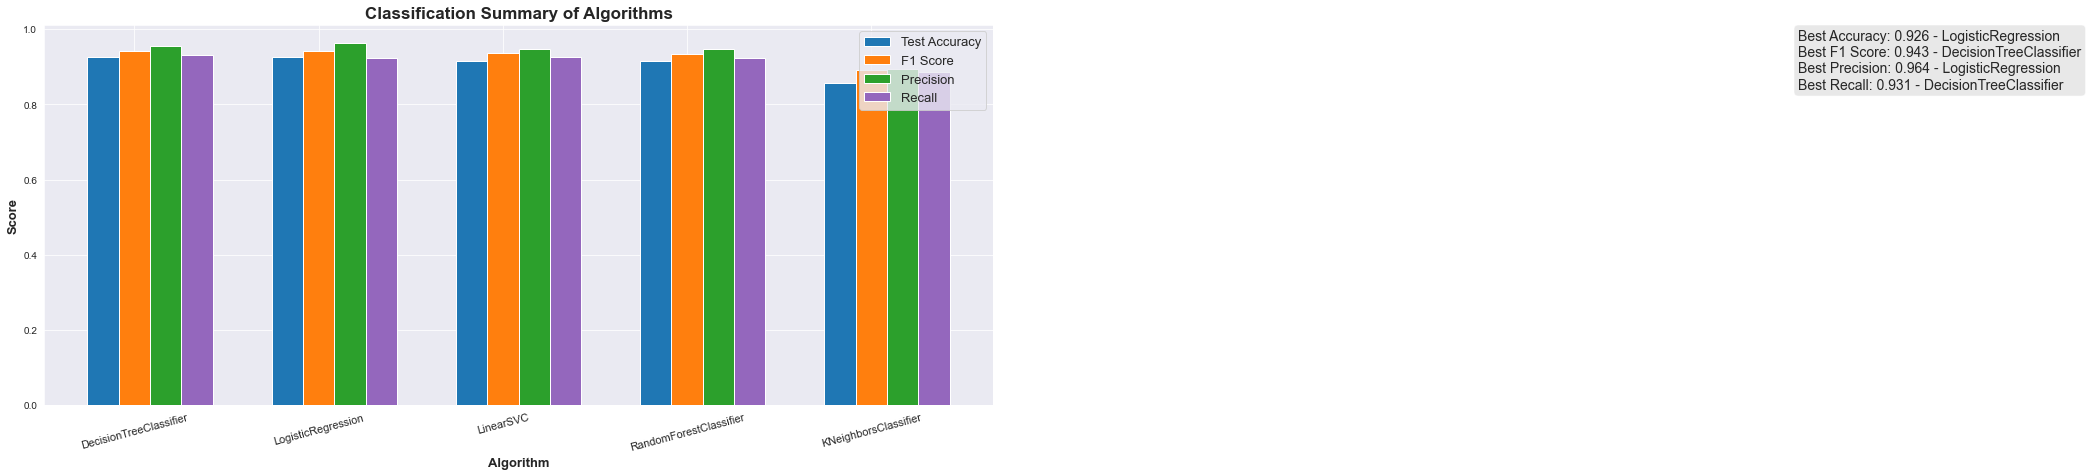

In [20]:
sns.set_style('darkgrid')
plt.figure(figsize = (17, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']
bars3 = results['Precision: Test']
bars4 = results['Recall: Test']

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

 
# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')
plt.bar(r3, bars3, color= pal[2], width=barWidth, edgecolor='white', label='Precision')
plt.bar(r4, bars4, color= pal[4], width=barWidth, edgecolor='white', label='Recall')

 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy: Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score: Test'].values[0], best_f1['Algorithm'].values[0]),
                   'Best Precision: {:.3f} - {}'.format(best_precision['Precision: Test'].values[0], best_precision['Algorithm'].values[0]), 
                    'Best Recall: {:.3f} - {}'.format(best_recall['Recall: Test'].values[0], best_recall['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9.2, 1, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

In [21]:
# store the best/worst performance time
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

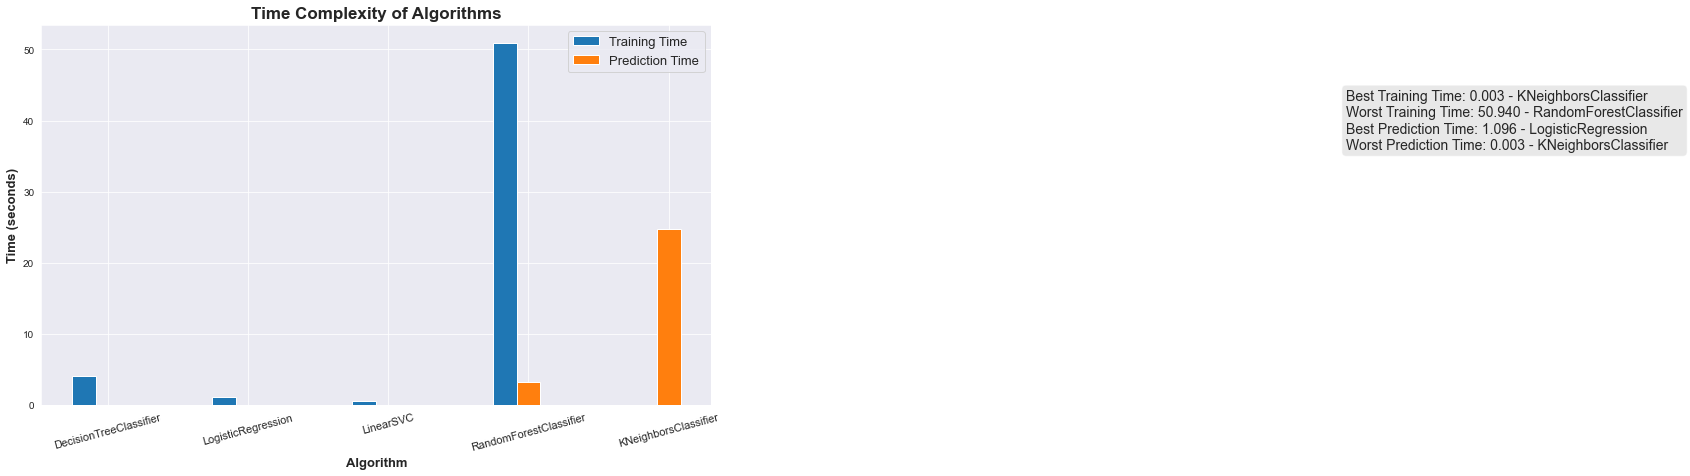

In [22]:
plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9, 36, textstr, fontsize=14,  bbox=props)

plt.title('Time Complexity of Algorithms', fontweight = 'bold', fontsize = 17);

> The Algorithms Bagging, SGD, Logistic Regression and Decision Tree and Random Forest and LinearSVC have more or less similar performance. We will tune the hyperparameters of these algorithms. However, the training time for Bagging is very high as compared to the others. Hence we drop it. 

### Tuning Hyperparameters
***

In [23]:
def param_tuning(clf, param_dict, X_train, y_train, X_test, y_test):
    
    # make scorer object
    scorer = make_scorer(f1_score)

    # perform Grid Search for Parameters
    grid_obj = GridSearchCV(estimator = clf,
                           param_grid = param_dict,
                           scoring = scorer,
                           cv = 5)

    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)
    print(best_predictions)
    print(predictions)
    
    # Report the before-and-afterscores
    print(clf.__class__.__name__)
    print("\nOptimized Model\n------")
    print("Best Parameters: {}".format(grid_fit.best_params_))
    print("Accuracy: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("F1-score: {:.4f}".format(f1_score(y_test, best_predictions)))
    print("Precision: {:.4f}".format(precision_score(y_test, best_predictions)))
    print("Recall: {:.4f}".format(recall_score(y_test, best_predictions)))

Stochastic Gradient Classifier:

In [24]:
# Dict for parameters
param_grid = {
    'alpha' : [0.095, 0.0002, 0.0003],
    'max_iter' : [2500, 3000, 4000]
}

clf_sgd = SGDClassifier()

param_tuning(clf_sgd, param_grid, training_data, y_train, testing_data, y_test)

[0 1 1 ... 0 1 1]
[0 1 1 ... 0 1 1]
SGDClassifier

Optimized Model
------
Best Parameters: {'alpha': 0.0002, 'max_iter': 4000}
Accuracy: 0.9280
F1-score: 0.9439
Precision: 0.9672
Recall: 0.9218


Logistic Regression Classifier:

Decision Tree Classifier:

In [25]:
param_grid = {
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 5, 8]
}

clf_dt = DecisionTreeClassifier()

param_tuning(clf_dt, param_grid, training_data, y_train, testing_data, y_test)

[0 1 1 ... 0 1 1]
[0 1 1 ... 0 1 1]
DecisionTreeClassifier

Optimized Model
------
Best Parameters: {'min_samples_leaf': 1, 'min_samples_split': 5}
Accuracy: 0.9253
F1-score: 0.9425
Precision: 0.9550
Recall: 0.9303


Random Forest Classifier:

### Conclusion:
***
We found Stochastic Gradient to be the best suited model for our data. We achieved the following performance parameters:
-	Accuracy: 92.81 %
-	Precision: 96.97 %
-	Recall: 91.94 %
-	F1-Score: 94.39 %

Save the model:

In [26]:
filename = 'cb_sgd_final.sav'
joblib.dump(clf_sgd, filename)

['cb_sgd_final.sav']

In [27]:
import streamlit as st
import tensorflow as tf
from PIL import Image

# Define the user interface
st.title('Image Classification App')
st.write('Upload an image or paste the file contents to classify it.')
file_input = st.file_uploader('Choose a file', type=['jpg', 'jpeg', 'png'])
file_contents = st.text_input('Or paste the file contents here')

if file_input is not None:
    # Load the image and preprocess it
    image = Image.open(file_input)
    image = image.resize((224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = tf.expand_dims(image, axis=0)

    # Make a prediction and display the result
    model = tf.keras.models.load_model('my_model.h5')
    prediction = model.predict(image)
    st.write('Prediction:', prediction)
elif file_contents:
    # Convert the file contents to an image and preprocess it
    image = Image.open(io.BytesIO(file_contents.encode()))
    image = image.resize((224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = tf.expand_dims(image, axis=0)

    # Make a prediction and display the result
    model = tf.keras.models.load_model('my_model.h5')
    prediction = model.predict(image)
    st.write('Prediction:', prediction)
else:
    st.warning('No file selected or contents pasted.')

ModuleNotFoundError: No module named 'streamlit'